# LSTM model on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

1. Number of reviews: 568,454
2. Number of users: 256,059
3. Number of products: 74,258
4. Timespan: Oct 1999 - Oct 2012
5. Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Objective:

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Steps done in this assignment:-


1. Load Libraries and Amazon reviews data
2. Done Data Cleaning and Text Pre-Processing
3. Sorting the data according to time 
4. Applying Tokenizer API of Keras on Reviews Data
5. Getting Vocabulary of words and their frequencies
6. Sorting words in descending order
7. Getting indices to words based on frequencies
8. Converting data to IMDB data format / each word is replaced with its index
9. Splitting data points into Train and Test data
10. Importing keras Libraries
11. Performing Padding on train data
12. LSTM Model with 1 LSTM layer and dropout
13. LSTM Model with 2 LSTM layers and dropout
14. Plotting the Loss vs Epoch Plot
15. Compiling the model

## 1. Loading Libraries and Amazon reviews data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   
3                     3                       3      0  1307923200   
4                     0                       0      1  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

## 2. Data Cleaning: Deduplication

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
print(final_data.shape)
#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 3. Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1] Preprocessing Review Text


In [7]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)


A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [8]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [9]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [10]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [12]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [13]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [15]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())
    

100%|██████████| 364171/364171 [03:23<00:00, 1791.82it/s]


In [18]:
final_data['CleanedText'] = final_strings
print('Final data shape', final_data.shape)
final_data.head(3)

Final data shape (364171, 11)


Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138706                     0                       0      1   939340800   
138688                     1                       1      1  1194739200   
138689                     1                       1      1  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  
138706  witty little book makes son laugh loud recite ...  
138688  grew reading sendak books watching really rosi...  
138689  fun way children learn months year learn poems...

In [19]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [20]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [21]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [22]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [24]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [25]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [02:05<00:00, 2901.08it/s]


In [28]:
summary_data[56000]

'awesome yummy'

In [29]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138706                     0                       0      1   939340800   
138688                     1                       1      1  1194739200   
138689                     1                       1      1  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  \
138706  witty little book makes son laugh loud recite ...   
138688  grew reading sendak books watching really rosi...   
138689  fun way children learn months year learn poems...   

                           CleanedSummary  
138706             every book educational  
138688  love book miss hard cover version  
138689           chicken soup rice months

In [63]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## 4. Sorting the data according to time 

In [64]:
# Time based sorting
final_data['Time'] = pd.to_datetime(final_data['Time'])
final_data = final_data.sort_values(by = 'Time', ascending = True)

# taking sample of 100000 data points
total_score = final_data.iloc[:100000,:]
print(total_score.shape)
print(total_score['Score'].value_counts())

X = total_score['CleanedText']
Y = total_score['Score']


(100000, 12)
1    87729
0    12271
Name: Score, dtype: int64


## 5. Applying Tokenizer API of Keras on Data

In [65]:
# reference - https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
# https://keras.io/preprocessing/text/#tokenizer
# tokenizer gives tokens of words from text data
from keras.preprocessing.text import Tokenizer

t = Tokenizer(num_words = 5000)
t.fit_on_texts(X)


### 5.1 Getting Vocabulary of words and their frequencies

In [66]:
# Getting words and their frequencies through Tokenizer attribute called word_counts
words = t.word_counts
print(words)
#print(t.word_counts)

OrderedDict([('witty', 5), ('little', 13155), ('book', 465), ('makes', 6849), ('son', 2130), ('laugh', 59), ('loud', 80), ('recite', 3), ('car', 480), ('driving', 134), ('along', 1363), ('always', 6046), ('sing', 45), ('refrain', 12), ('learned', 459), ('whales', 3), ('india', 306), ('drooping', 3), ('roses', 72), ('love', 20248), ('new', 3683), ('words', 302), ('introduces', 5), ('silliness', 2), ('classic', 463), ('willing', 276), ('bet', 210), ('still', 6553), ('able', 3004), ('memory', 136), ('college', 270), ('remember', 1144), ('seeing', 307), ('show', 434), ('aired', 3), ('television', 25), ('years', 6668), ('ago', 2396), ('child', 711), ('sister', 429), ('later', 1229), ('bought', 7791), ('lp', 3), ('day', 6890), ('thirty', 71), ('somethingi', 11), ('used', 9414), ('series', 86), ('books', 158), ('songs', 15), ('student', 97), ('teaching', 20), ('preschoolers', 3), ('turned', 920), ('whole', 5406), ('school', 652), ('purchasing', 935), ('cd', 53), ('children', 1003), ('traditio

In [67]:
print(len(words))

113078


### 5.2  Sorting words in descending order

In [68]:
# Sorting words in descending order according to frequencies
import operator
freq = operator.itemgetter(1)
dic_words = sorted(words.items(), reverse=True, key=freq)
print(dic_words)

[('not', 92922), ('like', 38374), ('good', 32293), ('great', 29528), ('tea', 27954), ('one', 27109), ('taste', 26399), ('product', 23937), ('would', 22403), ('flavor', 22366), ('love', 20248), ('coffee', 18264), ('no', 17022), ('get', 16735), ('really', 15463), ('best', 14908), ('use', 14521), ('much', 14211), ('amazon', 14112), ('also', 14092), ('find', 13775), ('make', 13187), ('little', 13155), ('time', 13006), ('food', 12824), ('tried', 12318), ('buy', 12124), ('even', 12104), ('price', 11337), ('better', 11332), ('well', 10964), ('try', 10655), ('eat', 10466), ('chocolate', 10447), ('sugar', 9975), ('found', 9629), ('used', 9414), ('first', 9105), ('could', 8966), ('sweet', 8293), ('drink', 8284), ('made', 8193), ('mix', 7965), ('delicious', 7844), ('bought', 7791), ('water', 7758), ('way', 7679), ('store', 7625), ('box', 7616), ('bag', 7491), ('two', 7366), ('tastes', 7358), ('since', 7286), ('many', 7270), ('add', 7218), ('think', 7195), ('order', 7128), ('recommend', 7050), ('f

In [69]:
print(len(dic_words))

113078


### 5.3  Getting indices to words based on word frequencies

In [70]:
# Getting indices to words based on frequencies through Tokenizer attribute called word_index, 
# word with high frequency had index of 1 and so on
index = t.word_index
print(index)


{'not': 1, 'like': 2, 'good': 3, 'great': 4, 'tea': 5, 'one': 6, 'taste': 7, 'product': 8, 'would': 9, 'flavor': 10, 'love': 11, 'coffee': 12, 'no': 13, 'get': 14, 'really': 15, 'best': 16, 'use': 17, 'much': 18, 'amazon': 19, 'also': 20, 'find': 21, 'make': 22, 'little': 23, 'time': 24, 'food': 25, 'tried': 26, 'buy': 27, 'even': 28, 'price': 29, 'better': 30, 'well': 31, 'try': 32, 'eat': 33, 'chocolate': 34, 'sugar': 35, 'found': 36, 'used': 37, 'first': 38, 'could': 39, 'sweet': 40, 'drink': 41, 'made': 42, 'mix': 43, 'delicious': 44, 'bought': 45, 'water': 46, 'way': 47, 'store': 48, 'box': 49, 'bag': 50, 'two': 51, 'tastes': 52, 'since': 53, 'many': 54, 'add': 55, 'think': 56, 'order': 57, 'recommend': 58, 'favorite': 59, 'milk': 60, 'day': 61, 'free': 62, 'makes': 63, 'nice': 64, 'cup': 65, 'go': 66, 'years': 67, 'know': 68, 'hot': 69, 'still': 70, 'never': 71, 'want': 72, 'bit': 73, 'dog': 74, 'ever': 75, 'without': 76, 'stuff': 77, 'every': 78, 'always': 79, 'give': 80, 'organ

In [71]:
# Tokenizer attribute word_docs gives A dictionary of words and in how many reviews each word appeared in.
print(t.word_docs)

defaultdict(<class 'int'>, {'along': 1311, 'still': 5894, 'willing': 269, 'drooping': 3, 'love': 17325, 'college': 255, 'memory': 131, 'little': 11019, 'loud': 75, 'bet': 203, 'driving': 127, 'whales': 3, 'introduces': 5, 'car': 447, 'learned': 443, 'always': 5501, 'new': 3162, 'son': 1804, 'roses': 58, 'laugh': 57, 'makes': 6344, 'silliness': 2, 'words': 287, 'classic': 396, 'witty': 5, 'book': 396, 'recite': 2, 'india': 243, 'able': 2841, 'sing': 42, 'refrain': 12, 'child': 641, 'whole': 4636, 'bought': 7149, 'somethingi': 11, 'children': 871, 'lives': 251, 'teaching': 20, 'seeing': 298, 'preschoolers': 3, 'show': 418, 'used': 8196, 'series': 81, 'student': 93, 'books': 136, 'years': 6036, 'ago': 2295, 'sister': 390, 'remember': 1073, 'songs': 13, 'turned': 897, 'day': 5937, 'cd': 40, 'thirty': 69, 'tradition': 125, 'aired': 3, 'school': 589, 'purchasing': 918, 'lp': 3, 'television': 24, 'later': 1160, 'everything': 2009, 'acting': 53, 'effects': 435, 'beetlejuice': 61, 'movie': 306,

In [72]:
# document_count gives An integer count of the total number of reviews that were used to fit the Tokenizer.
print(t.document_count)

100000


### 5.4  Converting data to IMDB format  / words are replaced with its index

In [73]:
# texts_to_sequences transforms each word in text data to sequence of integers
# each word is replaced with its index and stored in data
data = t.texts_to_sequences(X)

In [74]:
print(data[1])

[574, 1701, 1322, 67, 280, 864, 1336, 536, 45, 61, 4355, 37, 3858, 2645, 3575, 697, 93, 936, 686, 484, 2645, 645, 2946, 1929]


In [75]:
# Splitting entire data into train and test data
from sklearn.model_selection import train_test_split
X_train , X_test , Y_train , Y_test = train_test_split(data ,Y, test_size = 0.3, random_state = 0, shuffle = False)

In [76]:
print("Number of datapoints in X_train :",len(X_train))
print("Number of datapoints in X_test :",len(X_test))
print('Y_train shape', Y_train.shape)
print('Y_test shape', Y_test.shape)


Number of datapoints in X_train : 70000
Number of datapoints in X_test : 30000
Y_train shape (70000,)
Y_test shape (30000,)


In [77]:
print(X_train[1])

[574, 1701, 1322, 67, 280, 864, 1336, 536, 45, 61, 4355, 37, 3858, 2645, 3575, 697, 93, 936, 686, 484, 2645, 645, 2946, 1929]


## 6. Importing Keras Libraries

In [78]:
# Importing libraries
import numpy 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
numpy.random.seed(7)

### 6.1 Performing Padding on train data

1. Without padding, we are passing each seq of words to LSTM at each time, once completing the 1st seq, then we pass next seq and so on. This is like implementing SGD operation with batchsize = 1, which is very time taking and too slow.
2. So alternative idea is, performing SGD with batchsize = k. Eg:- if we have batchsize =5 , then we input 5 words (1st word of first seq, 1st word of second seq, 1st word of third seq, 1st word of fourth seq and 1st word of 5th seq)to LSTM at different time steps. Only first words of reviews goes into LSTM at 1st time step.
3. Next all 2nd words of k reviews , goes into LSTM at 2nd time step simultaneously. 3rd words of k reviews can go into LSTM at 3rd time step simultaneously and so on.
4. To perform this process of batchsize, all the reviews should be of same length, otherwise we can't batch the words and seq.
5. Without bacthing, its too slow, so Padding operation is done to allow batch update with some batchsize and it is important in LSTM, which speed up the training in LSTM
6. Especially for text sequences, padding is important , to perform batch update with a batch size.



In [79]:
# truncate and/or pad input sequences. Through padding I am converting each review/seq to same length.
# If a review has length more than max_review_length value, then we trucate it to the max_review_length value and discard
# remaining words. 
max_review_length = 200
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  574 1701 1322   67  280  864
 1336  536   45   61 4355   37 3858 2645 3575  697   93  936  68

In [80]:
#function to plot Binary Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,6))
    plt.plot(x, ty, 'b', label="Train Loss")
    plt.plot(x, vy, 'r', label="Validation/Test Loss")
    plt.title('\nBinary Crossentropy Loss VS Epochs')
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss-Train and Test loss')
    plt.legend()
    plt.grid()
    plt.show()

## 7. Embedding layer:-

1. It takes indices and returns vectors. It is used a lot in NLP tasks. It is similar to Word2vec.
2. If we give word 5 (eg) then it returns vector representation for that word. Embedding layer can be trained as part of model , but word2vec cannot be trained like that.
3. Each word is represented as 3618496 dimensional one-hot encoded vectors.



## 7.1 LSTM model with 1 LSTM layer and dropout

In [81]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [82]:
# creating the model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

embedding_vecor_length = 32
#Initializing the sequential model
model = Sequential()
# Embedding layer
# Here input is number of vocabulary(113078), output will be of size 32. So total values are,  input is 52089 vector 
# representing each word and output vector is of size 32, means 32 activation units. so number of parameters between input and 
# embedded layer is 113078*32 = 3618496

model.add(Embedding(len(words.keys()), embedding_vecor_length, input_length = max_review_length))
# Adding Dropout layer
model.add(Dropout(0.2))
# Adding first LSTM layer
# There are 100 LSTM's and each of these 100 LSTM's takes these 32-dim vector as inputs and each LSTM generate output parallely.
# LSTM keras has biases
model.add(LSTM(100)) 
# Adding Dropout
model.add(Dropout(0.2))
# Adding output layer
# Connecting all the outputs from LSTM layer and bias and connecting them to single sigmoid unit which generates Yi^ 
# There are 100 outputs +1 bias term = 101 parameters
model.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 32)           3618496   
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,671,797
Trainable params: 3,671,797
Non-trainable params: 0
_________________________________________________________________
None


### 7.2 Compiling the model

In [83]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [87]:
# Compiling the model 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fitting the model
# To fit the model, give input data, batch_size, number of epochs and validation/test data
# validation_split = 0.3
# validation_data=(X_test, Y_test)
history = model.fit(X_train, Y_train, epochs=10,  batch_size=128, verbose=2, validation_data=(X_test, Y_test))


Train on 70000 samples, validate on 30000 samples
Epoch 1/10
 - 327s - loss: 0.0851 - acc: 0.9699 - val_loss: 0.2590 - val_acc: 0.9186
Epoch 2/10
 - 331s - loss: 0.0782 - acc: 0.9734 - val_loss: 0.2710 - val_acc: 0.9186
Epoch 3/10
 - 300s - loss: 0.0711 - acc: 0.9761 - val_loss: 0.2774 - val_acc: 0.9120
Epoch 4/10
 - 310s - loss: 0.0667 - acc: 0.9773 - val_loss: 0.2880 - val_acc: 0.9189
Epoch 5/10
 - 315s - loss: 0.0615 - acc: 0.9794 - val_loss: 0.3094 - val_acc: 0.9168
Epoch 6/10
 - 294s - loss: 0.0551 - acc: 0.9816 - val_loss: 0.3120 - val_acc: 0.9169
Epoch 7/10
 - 324s - loss: 0.0513 - acc: 0.9827 - val_loss: 0.3442 - val_acc: 0.9102
Epoch 8/10
 - 332s - loss: 0.0501 - acc: 0.9827 - val_loss: 0.3185 - val_acc: 0.9154
Epoch 9/10
 - 318s - loss: 0.0465 - acc: 0.9842 - val_loss: 0.3589 - val_acc: 0.9147
Epoch 10/10
 - 320s - loss: 0.0421 - acc: 0.9863 - val_loss: 0.3650 - val_acc: 0.9159


###  7.3 Plotting the Loss vs Epoch Plot

Test score: 0.365007360058402
Test accuracy: 0.9158666666666667


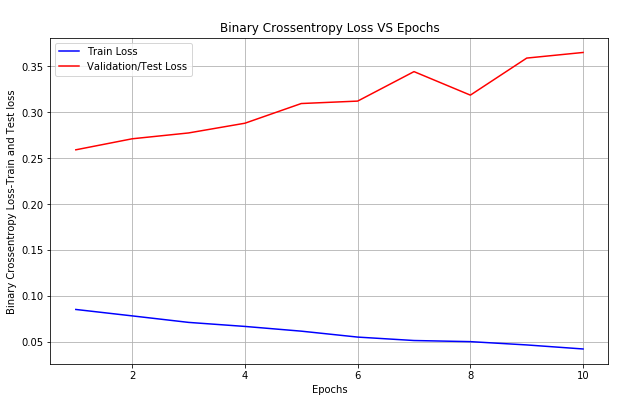

In [88]:
# Evaluating the model on test data
scores = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, 11))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

## 7.4 LSTM Model with 2 LSTM layers and dropout

In [89]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# creating the model
embedding_vecor_length = 32
#Initializing the sequential model
model_1 = Sequential()
model_1.add(Embedding(len(words.keys()), embedding_vecor_length, input_length = max_review_length))
# Adding Dropout layer
model_1.add(Dropout(0.5))
# Adding first LSTM layer
model_1.add(LSTM(100, return_sequences=True)) 
model_1.add(LSTM(100))
# Adding Dropout
model_1.add(Dropout(0.5))
# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           3618496   
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 100)          53200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 3,752,197
Trainable params: 3,752,197
Non-trainable params: 0
_________________________________________________________________


### 7.5 Compiling the model

In [90]:
# Compiling the model 
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model
# To fit the model, give input data, batch_size, number of epochs and validation/test data
# validation_split = 0.3
# validation_data=(X_test, Y_test)
history = model_1.fit(X_train, Y_train, epochs=10,  batch_size=128, verbose=2, validation_data=(X_test, Y_test))


Train on 70000 samples, validate on 30000 samples
Epoch 1/10
 - 728s - loss: 0.2378 - acc: 0.9120 - val_loss: 0.2010 - val_acc: 0.9189
Epoch 2/10
 - 732s - loss: 0.1733 - acc: 0.9344 - val_loss: 0.1976 - val_acc: 0.9232
Epoch 3/10
 - 667s - loss: 0.1588 - acc: 0.9414 - val_loss: 0.1955 - val_acc: 0.9252
Epoch 4/10
 - 2865s - loss: 0.1492 - acc: 0.9451 - val_loss: 0.1976 - val_acc: 0.9250
Epoch 5/10
 - 663s - loss: 0.1400 - acc: 0.9472 - val_loss: 0.1948 - val_acc: 0.9238
Epoch 6/10
 - 874s - loss: 0.1342 - acc: 0.9496 - val_loss: 0.1961 - val_acc: 0.9248
Epoch 7/10
 - 688s - loss: 0.1281 - acc: 0.9533 - val_loss: 0.2058 - val_acc: 0.9247
Epoch 8/10
 - 681s - loss: 0.1220 - acc: 0.9553 - val_loss: 0.2197 - val_acc: 0.9246
Epoch 9/10
 - 746s - loss: 0.1153 - acc: 0.9581 - val_loss: 0.2270 - val_acc: 0.9235
Epoch 10/10
 - 712s - loss: 0.1119 - acc: 0.9594 - val_loss: 0.2192 - val_acc: 0.9243


### 7.6 Plotting the Loss vs Epoch Plot

Test score: 0.21923840385725102
Test accuracy: 0.9243


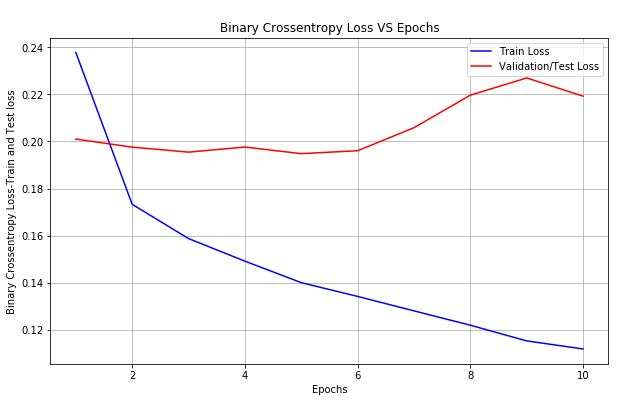

In [91]:
# Evaluating the model on test data
scores_1 = model_1.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', scores_1[0]) 
print('Test accuracy:', scores_1[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, 11))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

## 8. Models Summarization

In [92]:
from pandas import DataFrame
LSTM = {'LSTM Model':['1-LSTM layer','2-LSTM layers'], 
             'Activation':['Sigmoid','Sigmoid'],'Optimizer':['Adam','Adam'],
             'Loss':['binary_crossentropy', 'binary_crossentropy'],
             'Training accuracy':['0.98','0.95'], 'Train loss':['0.04','0.11'],
             'Test accuracy':['0.91','0.92'], 'Test loss':['0.36','0.21']}

In [93]:
Final_conclusions = DataFrame(LSTM)
Final_conclusions

LSTM Model Activation Optimizer                 Loss Training accuracy  \
0   1-LSTM layer    Sigmoid      Adam  binary_crossentropy              0.98   
1  2-LSTM layers    Sigmoid      Adam  binary_crossentropy              0.95   

  Train loss Test accuracy Test loss  
0       0.04          0.91      0.36  
1       0.11          0.92      0.21

# 9. Conclusions:-

From the above observations we can observe,

1. Both LSTM layers have good training and test accuracy. 
2. Model with one LSTM layer ran 10 epochs with batchsize = 128 and got test accuracy of 91%
3. Model with two LSTM layers also ran 10 epochs with same batchsize and got test accuracy of 92% 
4. With each epoch the accuracy increased.
5. I used sigmoid activation and Adam optimizer for LSTM 
6. Training accuracy is almost similar for both models. 